In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (16,7)
mpl.rcParams["image.origin"] = "lower"
mpl.rcParams["image.interpolation"] = "nearest"

from astropy.io import fits
from astropy.table import Table

# pysynphot for adjusting spectrum template
import pysynphot as S

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
# Pick out object; +5 x-offset
x_0 = 1891
y_0 = 1332

half_slice_width = 2 # x width
half_slice_length = 500 # y length

In [3]:
# Identify object for SPECTEMP
hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format='ascii')
hlss_tbl = hlss_tbl.group_by("MODIMAGE")
hlss_tbl.groups[0].sort("MAG_F1500W", reverse=True)
hlss_tbl.groups[1].sort("MAG_F1500W", reverse=True)

condition = (abs(hlss_tbl["X_IMAGE"] - x_0) <= 5) & (abs(hlss_tbl["Y_IMAGE"] - y_0) <= 5)
object = hlss_tbl[np.where(condition)]

object.pprint_all()
SPECTEMP = object["SPECTEMP"].value[0]
Z = object["Z"].value[0]
mag = object["MAG_F1500W"].value[0]

SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"
sed = f"SED:rest:gal.{SPECTEMP}.fits"

data = Table.read(os.path.join(SED_dir, sed), format='fits')

df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

spec = S.ArraySpectrum(data["wavelength"], data["flux"], waveunits="angstroms", fluxunits="flam").redshift(Z)
spec = spec.renorm(mag, "abmag", bp)
spec.convert("flam")

NUMBER  X_IMAGE   Y_IMAGE  A_IMAGE B_IMAGE THETA_IMAGE MAG_F1500W SPECTEMP    Z    MODIMAGE MODIMAGE_1 MODIMAGE_2
------ --------- --------- ------- ------- ----------- ---------- -------- ------- -------- ---------- ----------
 40384 1891.0789 1332.1173 11.2598  6.1885      341.95      16.23    40384 0.08786        0  9.4631792 -0.7584291
203510 1889.4064 1327.6441     8.0     8.0         0.0       24.5   197363     0.0        1    -1000.0    -1000.0


In [4]:
# Extract spectrum from model
file = fits.open("/Users/keith/astr/research_astr/summer-roman-project/predictable_extract/fits/straigh_line_model.fits")
data = file[1].data
file.close()

cutout = data[y_0-half_slice_length : y_0+half_slice_length, x_0-half_slice_width : x_0+half_slice_width]

max_extract = []
sum_extract = []
for ii in range(cutout.shape[0]):
    max_extract.append(cutout[ii].max())
    sum_extract.append(cutout[ii].sum()/(2*half_slice_width))

max_extract = np.asarray(max_extract)
sum_extract = np.asarray(sum_extract)

wave = np.linspace(10000, 20000, 2*half_slice_length)
max_spec = S.ArraySpectrum(wave=wave, flux=max_extract, waveunits="angstroms", fluxunits="counts")
sum_spec = S.ArraySpectrum(wave=wave, flux=sum_extract, waveunits="angstroms", fluxunits="counts")

# max_spec = max_spec.renorm(, , sens_bp)

max_spec.convert("flam")
sum_spec.convert("flam")

Text(0.5, 1.0, 'Extracted Spectrum')

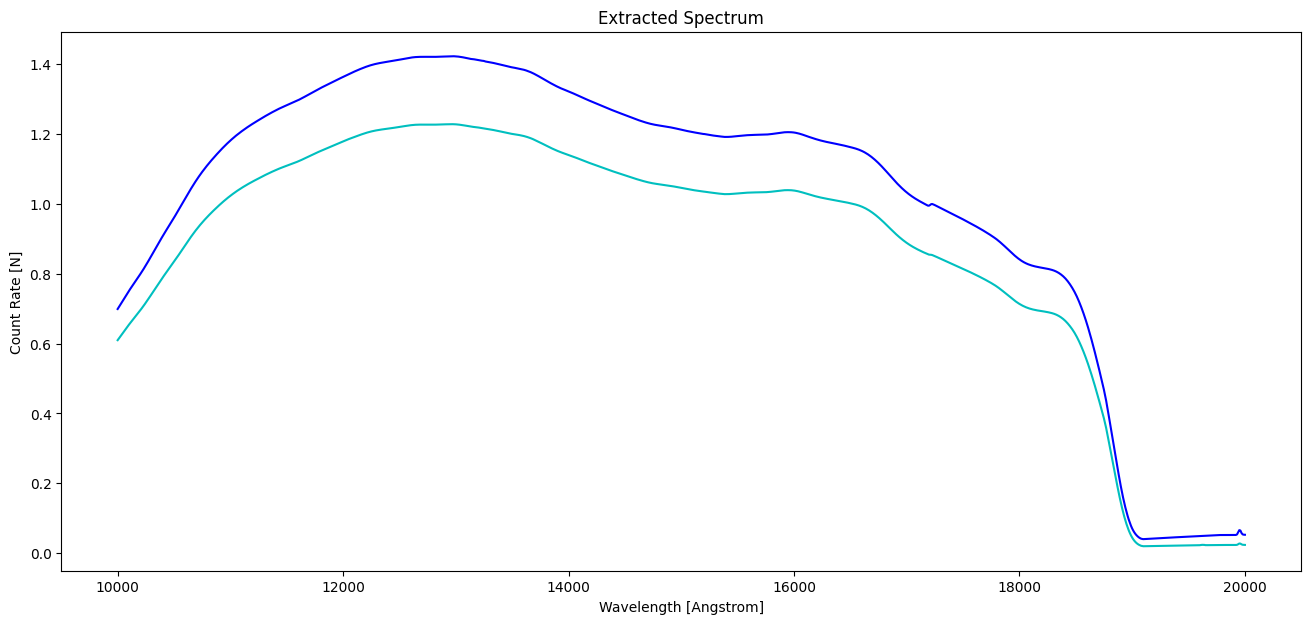

In [5]:
# Plot extractions against expected value
wave = np.linspace(10000, 20000, 2*half_slice_length)
plt.plot(wave, max_extract, c='b', label="Max values Extraction")
plt.plot(wave, sum_extract, c='c', label="Sum values Extraction")

plt.ylabel("Count Rate [N]")
plt.xlabel("Wavelength [Angstrom]")

plt.title("Extracted Spectrum")

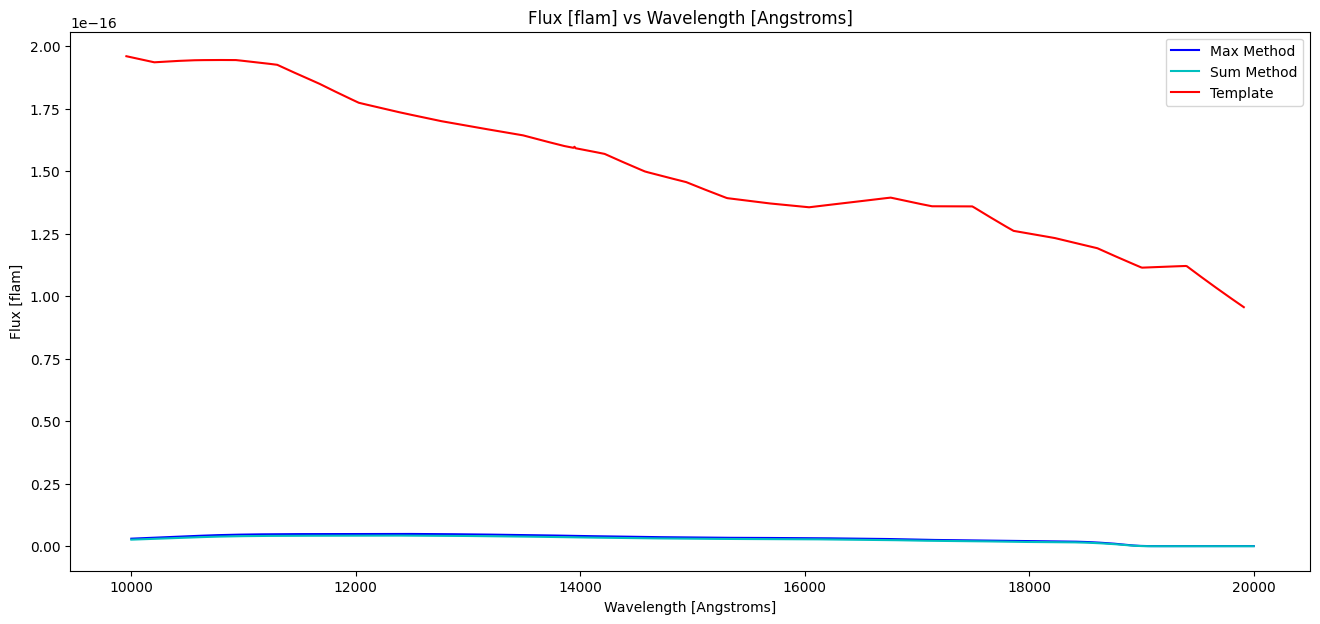

In [6]:
plt.plot(max_spec.wave, max_spec.flux, c='b', label="Max Method")
plt.plot(sum_spec.wave, sum_spec.flux, c='c', label="Sum Method")
plt.plot(spec.wave, spec.flux, c='r', label="Template")

plt.title("Flux [flam] vs Wavelength [Angstroms]")
plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux [flam]")
plt.legend()

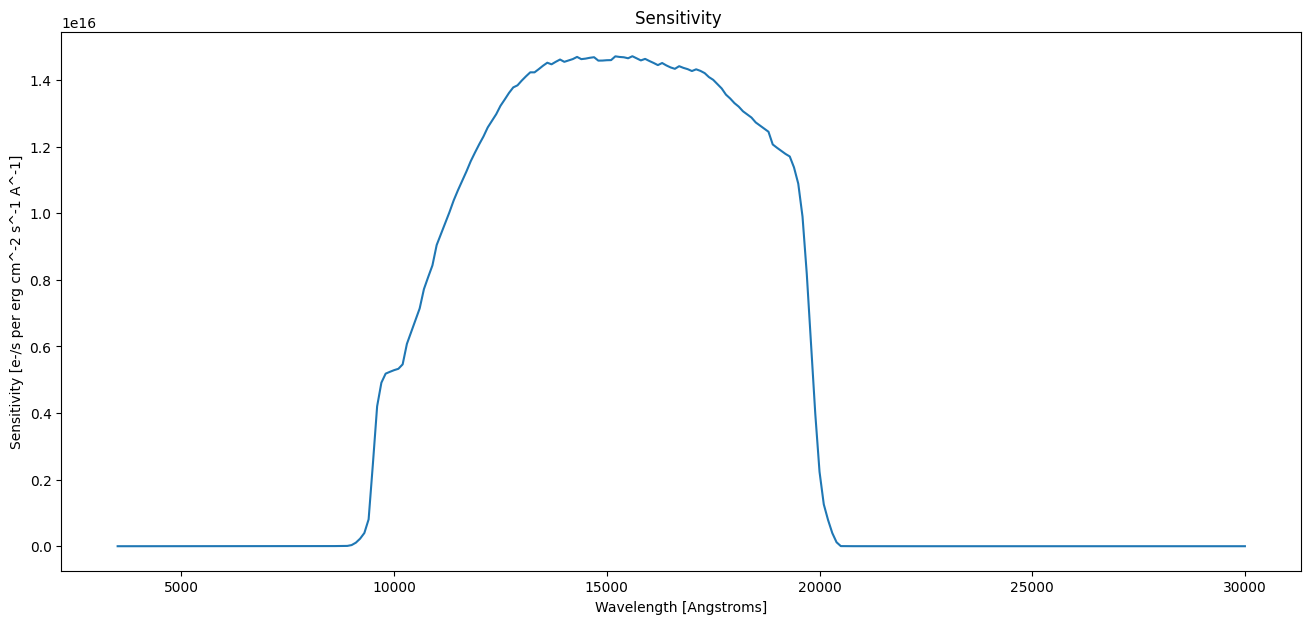

In [7]:
sens = Table.read("/Users/keith/astr/research_astr/summer-roman-project/toy_configs/sens_0720_2020.fits", format="fits")

plt.plot(sens["WAVELENGTH"], sens["SENSITIVITY"])
plt.title("Sensitivity ")
plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Sensitivity [e-/s per erg cm^-2 s^-1 A^-1]")

sens_bp = S.ArrayBandpass(sens["WAVELENGTH"], sens["SENSITIVITY"])
